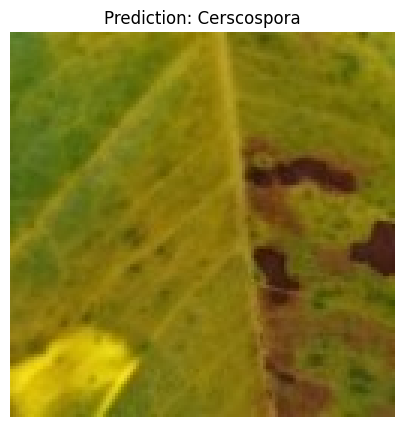

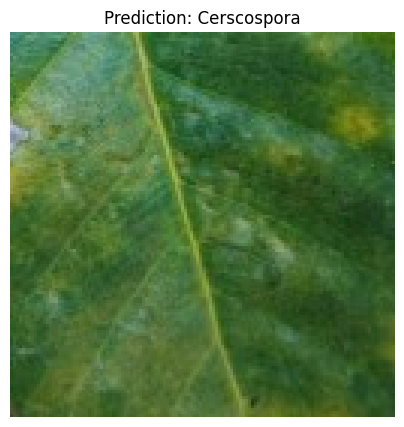

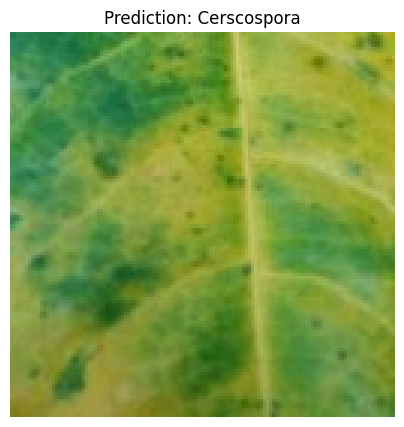

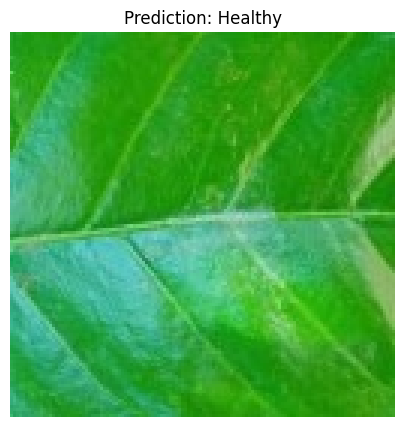

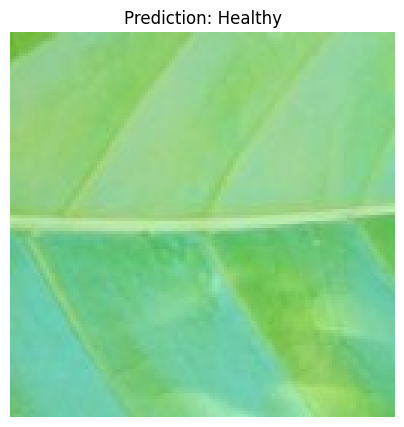

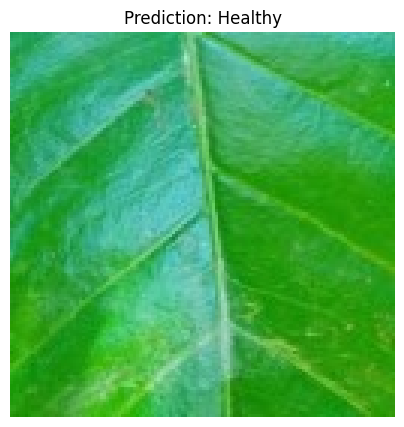

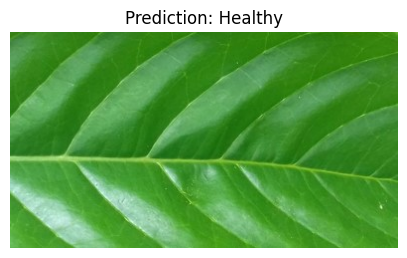

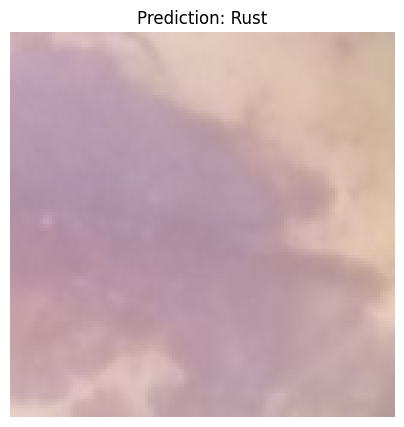

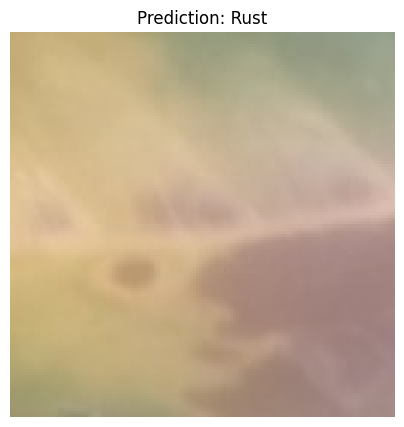

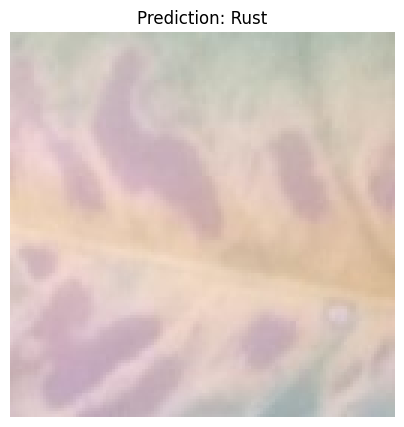

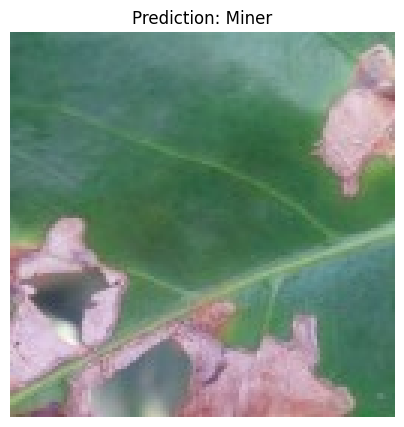

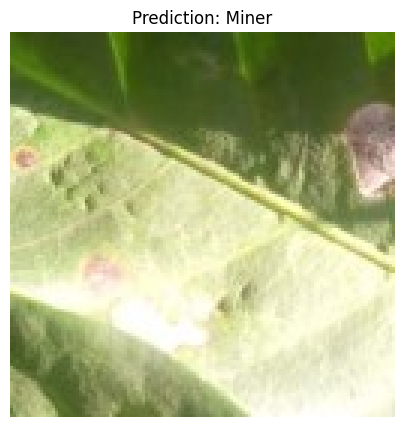

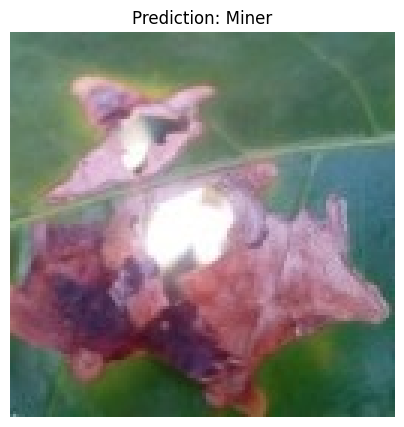

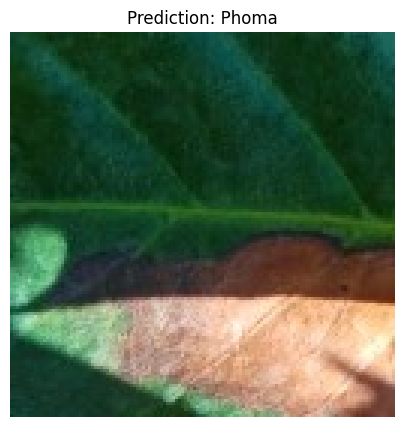

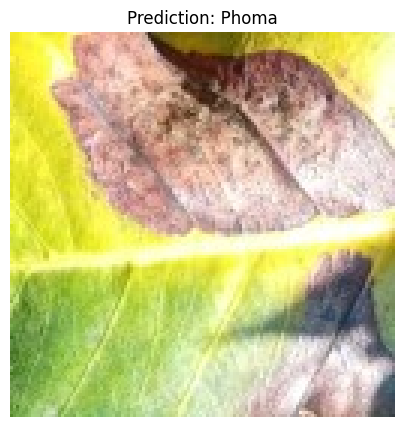

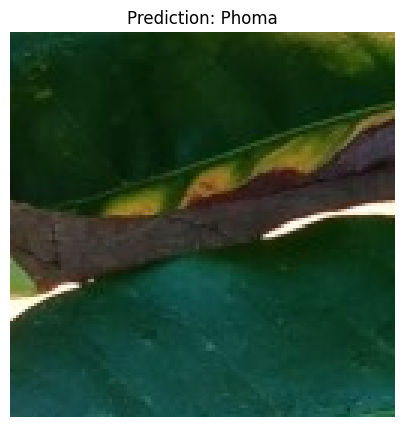

In [16]:
import torch
import cv2
import torchvision.transforms as transforms
from PIL import Image
import os
from torchvision import models
import matplotlib.pyplot as plt

def load_model(model_path, device):
    """Load ResNet50 model and apply trained weights."""
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        return None

    model = models.resnet50(pretrained=False)  # Initialize ResNet50
    num_ftrs = model.fc.in_features  # Get the number of input features for the last layer
    model.fc = torch.nn.Linear(num_ftrs, 5)  # Modify final layer to match 5 classes

    state_dict = torch.load(model_path, map_location=device)  # Load saved weights
    model.load_state_dict(state_dict)  # Apply weights

    model.to(device)
    model.eval()
    return model

def preprocess_image(image_path):
    """Preprocess an image: Resize, Convert to Tensor, and Normalize."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = Image.fromarray(image)  # Convert NumPy array to PIL Image

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return transform(image).unsqueeze(0), image  # Return Tensor & original RGB image

def visualize_predictions(model, image_folder, class_names, device):
    """Test all images in `image_folder` and print predictions."""
    if not os.path.exists(image_folder):
        print(f"Error: Image folder not found at {image_folder}")
        return

    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        
        if not os.path.exists(class_folder):
            print(f"Warning: Class folder {class_folder} not found, skipping...")
            continue

        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            image_tensor, original_image = preprocess_image(image_path)
            if image_tensor is None:
                continue

            image_tensor = image_tensor.to(device)  # Move image to device

            with torch.no_grad():
                prediction = model(image_tensor)
                predicted_class = torch.argmax(prediction, dim=1).item()
                predicted_label = class_names[predicted_class]

            # Plot image and prediction
            plt.figure(figsize=(5, 5))
            plt.imshow(original_image)  # Show RGB image from PIL
            plt.title(f"Prediction: {predicted_label}")
            plt.axis("off")
            plt.show()


# Define model and class names
model_path = "./model/resnet50_coffee.pth"
image_folder = "../data sample/"  # Update with your actual test image folder
class_names = ["Cerscospora", "Healthy", "Rust", "Miner", "Phoma"]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = load_model(model_path, device)
if model:
    visualize_predictions(model, image_folder, class_names, device)
